In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os


/home/malaika/anaconda3/envs/computervision/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/malaika/anaconda3/envs/computervision/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/malaika/anaconda3/envs/computervision/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/malaika/anaco

In [2]:
from skimage.transform import resize
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
tf.__version__

'1.13.1'

# Load csv

In [5]:


df = pd.read_csv('/media/malaika/Windows/Users/utilisateur/Desktop/projet_appliquer/galaxy_zoo/data_galaxy_zoo/training_solutions_rev1.csv')

df_test = pd.read_csv('/media/malaika/Windows/Users/utilisateur/Desktop/projet_appliquer/galaxy_zoo/new_images_for_test.csv')

img_class = df.loc[:,['GalaxyID', 'Class1.1', 'Class1.2','Class1.3']]

In [6]:
img_class

,GalaxyID,Class1.1,Class1.2,Class1.3
0,100008,0.383147,0.616853,0.000000
1,100023,0.327001,0.663777,0.009222
2,100053,0.765717,0.177352,0.056931
3,100078,0.693377,0.238564,0.068059
4,100090,0.933839,0.000000,0.066161
...,...,...,...,...
61573,999948,0.510379,0.489621,0.000000
61574,999950,0.901216,0.098784,0.000000
61575,999958,0.202841,0.777376,0.019783
61576,999964,0.091000,0.909000,0.000000


## We remove the image that we did not process

In [7]:

indexNames = img_class[ img_class['GalaxyID'] == 383063 ].index
 
# Delete these row indexes from dataFrame
img_class.drop(indexNames , inplace=True)

In [8]:
dossier_images = 'resized_crop_images'

# Create, Crop and resize XTrain 

In [9]:

SEED = 42
df_train, df_test = train_test_split(img_class, test_size=0.2, random_state=SEED)

## We get X and Y

In [10]:
from skimage.transform import resize
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

def get_image(path):
    x = plt.imread(path)
    return x
    
def get_all_images(dataframe):
    sel = dataframe.values
    ids = sel[:,0].astype(int).astype(str)
    y_batch = sel[:,1:]
    x_batch = []
    for i in tqdm(ids):
        x = get_image(f'/media/malaika/Windows/Users/utilisateur/Desktop/projet_appliquer/galaxy_zoo/data_galaxy_zoo/images_training_rev1/{dossier_images}/{i}.jpg')
        x_batch.append(x/255) # normalisation x 
    x_batch = np.array(x_batch)
    return x_batch, y_batch
        
X_train, y_train = get_all_images(df_train)
X_test, y_test = get_all_images(df_test)

100%|██████████| 12316/12316 [00:06<00:00, 1885.72it/s]


In [11]:
#Rename Test
X_val = X_test.copy()
y_val = y_test.copy()

In [12]:
print('X_train',X_train.shape)
print('y_train',y_train.shape)
print('X_val',X_val.shape)
print('y_val',y_val.shape)


X_train (49261, 64, 64, 3)
y_train (49261, 3)
X_val (12316, 64, 64, 3)
y_val (12316, 3)


In [13]:
np.save('X_train', X_train)
np.save('y_train', y_train)
np.save('X_val', X_val)
np.save('y_val', y_val)

# Load npy if already save

In [14]:
import numpy as np
 
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_val = np.load('X_val.npy')
y_val = np.load('y_val.npy')

# CNN model

In [12]:
from IPython.display import Image
Image("cnn.png")

FileNotFoundError: No such file or directory: 'cnn.png'

FileNotFoundError: No such file or directory: 'cnn.png'

<IPython.core.display.Image object>

**Definition:**  
[keras doc](https://keras.io/layers/core/)  

* Conv2D : 
``` 
keras.backend.conv2d(x, kernel, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1))
```
  
* Dropout : Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting.    
* Flatten : Flattens the input. Does not affect the batch size  


## CNN with Sigmoid

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras import backend as K

#def root_mean_squared_error(y_true, y_pred):
#        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

IMG_SHAPE = (64,64)

model = Sequential()

model.add(Conv2D(8, (3, 3), input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3)))
model.add(Conv2D(16, (3, 3)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Conv2D(16, (3, 3)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(8, (3, 3)))
model.add(Conv2D(8, (3, 3)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(GlobalMaxPooling2D())


model.add(Dropout(0.25))
model.add(Dense(8))
model.add(Activation('relu'))

model.add(Dropout(0.25))
model.add(Dense(8))
model.add(Activation('relu'))

model.add(Dropout(0.25))
model.add(Dense(8))
model.add(Activation('relu'))

model.add(Dropout(0.25))
model.add(Dense(3)) # on ne test que les 3 premières classe
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['mae', 'acc'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 8)         224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 16)        1168      
_________________________________________________________________
activation (Activation)      (None, 60, 60, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)    

In [15]:
#batch_size = 128
#batch_size = 49262
epochs=30
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val))

Train on 49261 samples, validate on 12316 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/30
49261/49261 [==============================] - 186s 4ms/sample - loss: 0.8034 - mean_absolute_error: 0.2127 - acc: 0.5886 - val_loss: 0.7295 - val_mean_absolute_error: 0.1560 - val_acc: 0.7671
Epoch 2/30
49261/49261 [==============================] - 197s 4ms/sample - loss: 0.7407 - mean_absolute_error: 0.1682 - acc: 0.7198 - val_loss: 0.7208 - val_mean_absolute_error: 0.1735 - val_acc: 0.7397
Epoch 3/30
49261/49261 [==============================] - 201s 4ms/sample - loss: 0.7236 - mean_absolute_error: 0.1634 - acc: 0.7583 - val_loss: 0.7028 - val_mean_absolute_error: 0.1568 - val_acc: 0.7800
Epoch 4/30
49261/49261 [==============================] - 205s 4ms/sample - loss: 0.7114 - mean_absolute_error: 0.1512 - acc: 0.7737 - val_loss: 0.6917 - val_mean_absolute_error: 0.1451 - val_acc: 0.8032
Epoch 5/

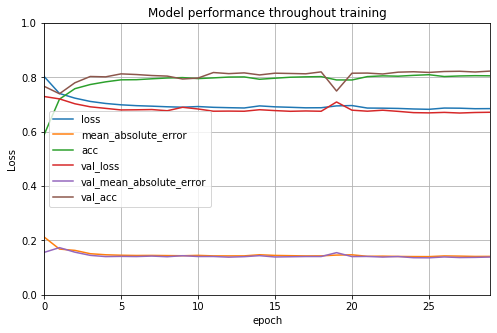

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title('Model performance throughout training')
plt.ylim(0,1)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()


## We are trying Softmax

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras import backend as K

#def root_mean_squared_error(y_true, y_pred):
#        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

IMG_SHAPE = (64,64)

model = Sequential()

model.add(Conv2D(8, (3, 3), input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3)))
model.add(Conv2D(16, (3, 3)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Conv2D(16, (3, 3)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(8, (3, 3)))
model.add(Conv2D(8, (3, 3)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(GlobalMaxPooling2D())


model.add(Dropout(0.25))
model.add(Dense(8))
model.add(Activation('relu'))

model.add(Dropout(0.25))
model.add(Dense(8))
model.add(Activation('relu'))

model.add(Dropout(0.25))
model.add(Dense(8))
model.add(Activation('relu'))

model.add(Dropout(0.25))
model.add(Dense(3)) # on ne test que les 3 premières classe
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['mae', 'acc'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 8)         224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 16)        1168      
_________________________________________________________________
activation (Activation)      (None, 60, 60, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)    

In [ ]:
#batch_size = 128
#batch_size = 49262
epochs=30
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val))

Train on 49261 samples, validate on 12316 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/30
49261/49261 [==============================] - 206s 4ms/sample - loss: 0.7792 - mean_absolute_error: 0.1653 - acc: 0.6532 - val_loss: 0.7160 - val_mean_absolute_error: 0.1362 - val_acc: 0.7769
Epoch 2/30
49261/49261 [==============================] - 199s 4ms/sample - loss: 0.7333 - mean_absolute_error: 0.1408 - acc: 0.7388 - val_loss: 0.7002 - val_mean_absolute_error: 0.1249 - val_acc: 0.7893
Epoch 3/30
49261/49261 [==============================] - 198s 4ms/sample - loss: 0.7196 - mean_absolute_error: 0.1328 - acc: 0.7639 - val_loss: 0.6975 - val_mean_absolute_error: 0.1242 - val_acc: 0.8001
Epoch 4/30
49261/49261 [==============================] - 205s 4ms/sample - loss: 0.7138 - mean_absolute_error: 0.1293 - acc: 0.7727 - val_loss: 0.6990 - val_mean_absolute_error: 0.1230 - val_acc: 0.7722
Epoch 5/

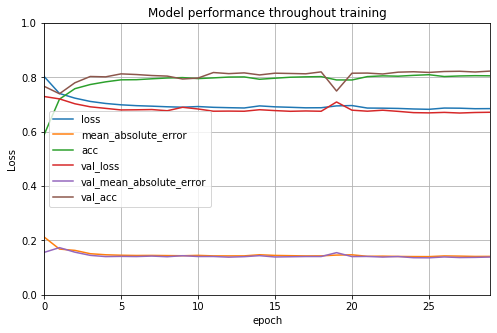

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title('Model performance throughout training')
plt.ylim(0,1)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras import backend as K

#def root_mean_squared_error(y_true, y_pred):
#        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

IMG_SHAPE = (64,64)

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3)))
model.add(Conv2D(16, (3, 3)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))



model.add(Conv2D(8, (3, 3)))
model.add(Conv2D(8, (3, 3)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(GlobalMaxPooling2D())



model.add(Dropout(0.25))

#
model.add(Dense(16))
model.add(Activation('relu'))


model.add(Dense(3)) # on ne test que les 3 premières classe
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['mae', 'acc'])
model.summary()

In [ ]:
#batch_size = 128
#batch_size = 49262
epochs=20
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val))

NameError: name 'plt' is not defined

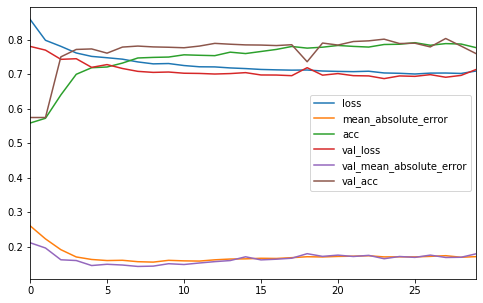

In [11]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title('Model performance throughout training')
plt.ylim(0,1)
plt.xlim(0,12)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()


In [18]:
y_train


array([[0.32538 , 0.646283, 0.028337],
       [0.246315, 0.753685, 0.      ],
       [0.776   , 0.145   , 0.079   ],
       ...,
       [0.457719, 0.525546, 0.016735],
       [0.343315, 0.637737, 0.018948],
       [0.493588, 0.485177, 0.021236]])

## We are trying Transfer Learning with RESNET

In [19]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

NUM_CLASSES = 3
RESNET_WEIGHTS_PATH = './resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5' #importing a pretrained model

model = Sequential()
model.trainable = False
model.add(ResNet50(include_top=False, pooling='max', weights=RESNET_WEIGHTS_PATH))
model.add(Dense(NUM_CLASSES, activation='softmax'))

#my_model_resnet = (ResNet50(include_top=False, pooling='max', weights=RESNET_WEIGHTS_PATH))
# Compile Model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
# Model Sum
model.summary()
# Fit Model
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=128)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 6147      
Total params: 23,593,859
Trainable params: 23,540,739
Non-trainable params: 53,120
_________________________________________________________________
Train on 49261 samples, validate on 12316 samples
Epoch 1/5
49261/49261 [==============================] - 3925s 80ms/sample - loss: 0.7950 - acc: 0.7843 - val_loss: 0.9752 - val_acc: 0.5667
Epoch 2/5
49261/49261 [==============================] - 3981s 81ms/sample - loss: 0.7044 - acc: 0.8257 - val_loss: 0.8609 - val_acc: 0.5142
Epoch 3/5
49261/49261 [==============================] - 3951s 80ms/sample - loss: 0.7037 - acc: 0.8345 - val_loss: 0.7241 - val_acc: 0.7216
Epoch 4/5
49261/49261 [=========================